v2
7/11/2018

In [1]:
import argparse
import os
import glob
import numpy as np
import cv2
import torch
import sys
import time

from WSI_handling import wsi

import math

from shapely.geometry import Polygon

In [2]:
from unet import UNet

In [3]:
#-----helper function to split data into batches
def divide_batch(l, n): 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [4]:
# ----- parse command line arguments
parser = argparse.ArgumentParser(description='Make output for entire image using Unet')
parser.add_argument('input_pattern',
                    help="input filename pattern. try: *.png, or tsv file containing list of files to analyze",
                    nargs="*")

_StoreAction(option_strings=[], dest='input_pattern', nargs='*', const=None, default=None, type=None, choices=None, help='input filename pattern. try: *.png, or tsv file containing list of files to analyze', metavar=None)

In [5]:
parser.add_argument('-r', '--resolution', help="image resolution in microns per pixel", default=1, type=float)
parser.add_argument('-c', '--color', help="annotation color to use, default None", default='green', type=str)
parser.add_argument('-a', '--annotation', help="annotation index to use, default largest", default='wsi', type=str)

parser.add_argument('-p', '--patchsize', help="patchsize, default 256", default=256, type=int)
parser.add_argument('-s', '--batchsize', help="batchsize for controlling GPU memory usage, default 10", default=10, type=int)
parser.add_argument('-o', '--outdir', help="outputdir, default ./output/", default="./output/", type=str)
parser.add_argument('-m', '--model', help="model", default="best_model.pth", type=str)
parser.add_argument('-i', '--gpuid', help="id of gpu to use", default=0, type=int)
parser.add_argument('-f', '--force', help="force regeneration of output even if it exists", default=False,
                    action="store_true")
parser.add_argument('-b', '--basepath',
                    help="base path to add to file names, helps when producing data using tsv file as input",
                    default="", type=str)

_StoreAction(option_strings=['-b', '--basepath'], dest='basepath', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='base path to add to file names, helps when producing data using tsv file as input', metavar=None)

In [33]:
args = parser.parse_args(['-s150','-o/mnt/rstor/CSE_BME_AXM788/home/pjl54/test','-r0.25','-a','largest','-m','/home/pjl54/models/nucer_unet_best_model.pth','/mnt/rstor/CSE_BME_AXM788/data/TCGA_Bladder_Cancer/Diagnostic_Images/Elloitt/2ndAnnotatedDrElloitt/TCGA-ZF-AA5P-01Z-00-DX1.svs'])

In [24]:
if not (args.input_pattern):
    parser.error('No images selected with input pattern')

In [25]:
OUTPUT_DIR = args.outdir


In [26]:
batch_size = args.batchsize
patch_size = args.patchsize
base_stride_size = patch_size//2

In [27]:
# ----- load network
device = torch.device(args.gpuid if torch.cuda.is_available() else 'cpu')

In [12]:
checkpoint = torch.load(args.model, map_location=lambda storage, loc: storage) #load checkpoint to CPU and then put to device https://discuss.pytorch.org/t/saving-and-loading-torch-models-on-2-machines-with-different-number-of-gpu-devices/6666
model = UNet(n_classes=checkpoint["n_classes"], in_channels=checkpoint["in_channels"],
             padding=checkpoint["padding"], depth=checkpoint["depth"], wf=checkpoint["wf"],
             up_mode=checkpoint["up_mode"], batch_norm=checkpoint["batch_norm"]).to(device)
model.load_state_dict(checkpoint["model_dict"])
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 3

In [28]:
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	487298


----- get file list

In [29]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [34]:
files = []
basepath = args.basepath  #
basepath = basepath + os.sep if len(
    basepath) > 0 else ""  # if the user supplied a different basepath, make sure it ends with an os.sep

In [35]:
if len(args.input_pattern) > 1:  # bash has sent us a list of files
    files = args.input_pattern
elif args.input_pattern[0].endswith("tsv"):  # user sent us an input file
    # load first column here and store into files
    with open(args.input_pattern[0], 'r') as f:
        for line in f:
            if line[0] == "#":
                continue
            files.append(basepath + line.strip().split("\t")[0])
else:  # user sent us a wildcard, need to use glob to find files
    files = glob.glob(args.basepath + args.input_pattern[0])

In [75]:
for fname in files:    
    fname = fname.strip()
    newfname_class = "%s/%s_class.png" % (OUTPUT_DIR, os.path.basename(fname)[0:fname.rfind('.')])

    print(f"working on file: \t {fname}")
    print(f"saving to : \t {newfname_class}")

#     if not args.force and os.path.exists(newfname_class):
#         print("Skipping as output file exists")
#         continue
    start_time = time.time()
    cv2.imwrite(newfname_class, np.zeros(shape=(1, 1)))                                            

    xml_dir = fname[0:fname.rfind(os.path.sep)]
    xml_fname = xml_dir + os.path.sep + os.path.basename(fname)[0:os.path.basename(fname).rfind('.')] + '.xml'

    img = wsi(fname,xml_fname)

    stride_size = int(base_stride_size * (args.resolution/img["mpp"]))

    if(args.annotation.lower() == 'wsi'):
        img_dims = [0,0,img["img_dims"][0][0],img["img_dims"][0][1]]
    else:
        img_dims = img.get_dimensions_of_annotation(args.color,args.annotation)

    if img_dims:

        x_start = int(img_dims[0])
        y_start = int(img_dims[1])
        w_orig = img.get_coord_at_mpp(img_dims[2] - x_start,input_mpp=img['mpp'],output_mpp=args.resolution)
        h_orig = img.get_coord_at_mpp(img_dims[3] - y_start,input_mpp=img['mpp'],output_mpp=args.resolution)


        w = int(w_orig + (patch_size - (w_orig % patch_size)))
        h = int(h_orig + (patch_size - (h_orig % patch_size)))

        base_edge_length = base_stride_size*int(math.sqrt(batch_size))        
    
        divisible_wh = tuple([k + ((base_edge_length + base_stride_size) - (k % (base_edge_length + base_stride_size))) for k in [w,h]])
            
#         roi = img.get_tile(args.resolution,(x_start-stride_size//2,y_start-stride_size//2),divisible_wh)
        roi = img.get_tile(args.resolution,(x_start-stride_size//2,y_start-stride_size//2),(w+patch_size,h+patch_size))
        x_points = range(0,np.shape(roi)[0],base_stride_size*int(math.sqrt(batch_size)))
        y_points = range(0,np.shape(roi)[1],base_stride_size*int(math.sqrt(batch_size)))
        grid_points = [(x,y) for x in x_points for y in y_points]                

        output = np.zeros([np.shape(roi)[0],np.shape(roi)[1]],dtype='uint8')
        
        for i,batch_points in enumerate(grid_points):

            # get the tile of the batch
            big_patch = roi[batch_points[0]:(batch_points[0]+base_edge_length+base_stride_size),batch_points[1]:(batch_points[1]+base_edge_length+base_stride_size),:]

            # split the tile into patch_size patches
            batch_arr = np.array([big_patch[x:x+patch_size,y:y+patch_size,:] for y in range(0,np.shape(big_patch)[1]-base_stride_size,base_stride_size) for x in range(0,np.shape(big_patch)[0]-base_stride_size,base_stride_size)])
        
            arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

            # ---- get results
            output_batch = model(arr_out_gpu)

            # --- pull from GPU and append to rest of output 
            output_batch = output_batch.detach().cpu().numpy()
            output_batch = output_batch.argmax(axis=1)
            
            #remove the padding from each tile, we only keep the center            
            output_batch = output_batch[:,base_stride_size//2:-base_stride_size//2,base_stride_size//2:-base_stride_size//2]            
            
            reconst = np.concatenate(np.concatenate(output_batch.reshape(int(np.shape(big_patch)[1]/(patch_size//2))-1,int(np.shape(big_patch)[0]/(patch_size//2))-1,base_stride_size,base_stride_size),axis=2),axis=0)

            output[batch_points[0]:(batch_points[0]+np.shape(big_patch)[0]-base_stride_size),batch_points[1]:(batch_points[1]+np.shape(big_patch)[1]-base_stride_size)] = reconst


        if(args.annotation.lower() == 'wsi'):
            cv2.imwrite(newfname_class,(output>0)*255)
        else:

        #in case there was extra padding to get a multiple of patch size, remove that as well
            _,mask = img.get_annotated_region(args.resolution,args.color,args.annotation,return_img=False)
            output_pre = output
            output = output[0:mask.shape[0], 0:mask.shape[1]] #remove paddind, crop back
            output = np.bitwise_and(output>0,mask>0)*255
            cv2.imwrite(newfname_class, output)

    else:
        print('No annotation of color')

    output = None
    output_batch = None
    mask = None
    print('Elapsed time = ' + str(time.time()-start_time))

working on file: 	 /mnt/rstor/CSE_BME_AXM788/data/TCGA_Bladder_Cancer/Diagnostic_Images/Elloitt/2ndAnnotatedDrElloitt/TCGA-ZF-AA5P-01Z-00-DX1.svs
saving to : 	 /mnt/rstor/CSE_BME_AXM788/home/pjl54/test/TCGA-ZF-AA5P-01Z-00-DX1.svs_class.png
Elapsed time = 287.44285821914673


In [73]:
print([img_dims[k]-img_dims[k-2] for k in [2,3]])
print([w,h])
print([k/patch_size for k in [w,h]])
print([k/patch_size for k in np.shape(roi)])
print(np.shape(roi))
print(np.shape(output_pre))
print(np.shape(mask))

[36261.0, 16034.0]
[36864, 16384]
[144.0, 64.0]
[64.5, 144.5, 0.01171875]
(16512, 36992, 3)
(16256, 36480)
(16207, 36652)


In [74]:
patch_size - (w_orig % patch_size)

212

(0, 36864)
(1664, 128, 3)


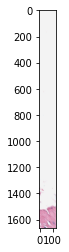

In [70]:
print(batch_points)
print(np.shape(big_patch))
# import matplotlib.pyplot as plt
plt.imshow(big_patch)
plt.show()

In [65]:
print(img.get_dimensions_of_annotation('green','largest'))
points, _ = img.get_points('green')

poly_list = [Polygon(point_set) for point_set in points]

areas = [poly.area for poly in poly_list]
annotation_idx = areas.index(max(areas))
bounding_box = poly_list[annotation_idx].bounds
print(bounding_box)
print([bounding_box[k]-bounding_box[k-2] for k in [2,3]])

(25080.0, 38981.0, 61341.0, 55015.0)
(25080.0, 38981.0, 61341.0, 55015.0)
[36261.0, 16034.0]


In [22]:
newfname_class = '/mnt/rstor/CSE_BME_AXM788/home/pjl54/test/TCGA-4Z-AA7O-01Z-00-DX1.svs_class.png'
cv2.imwrite(newfname_class, out)

True

/usr/local/gcc-6_3_0/openmpi-2_0_1/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


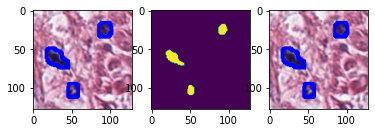

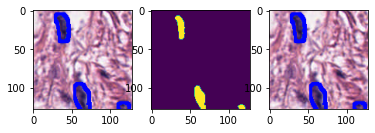

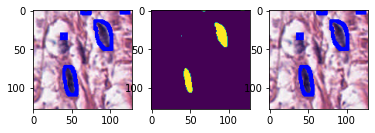

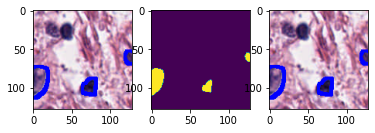

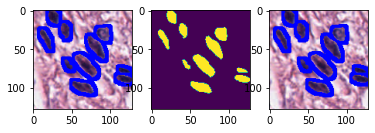

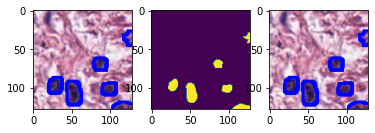

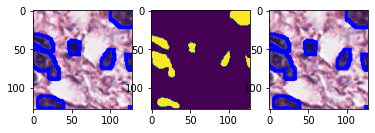

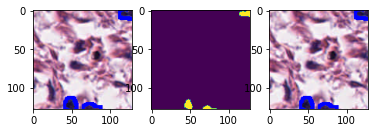

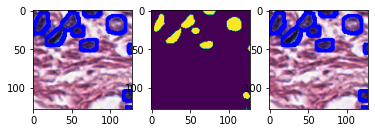

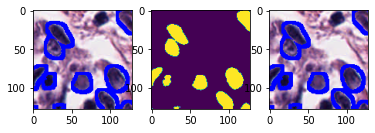

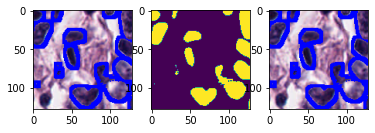

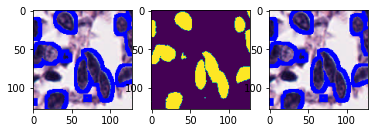

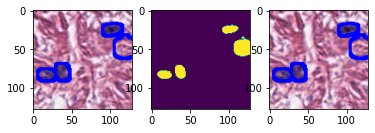

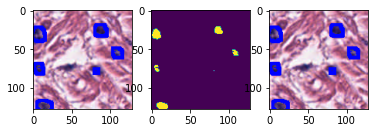

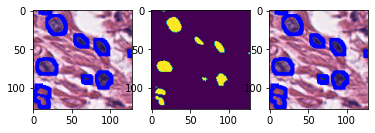

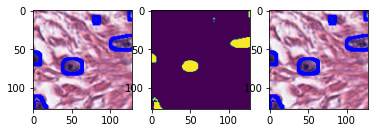

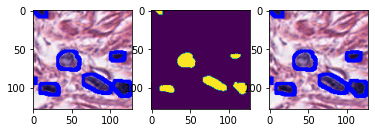

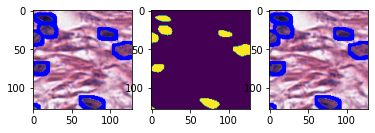

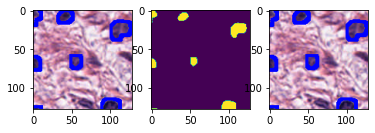

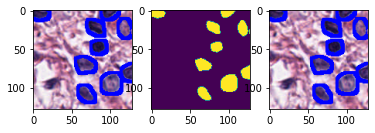

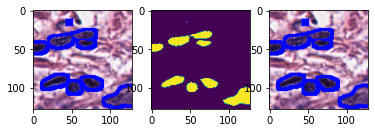

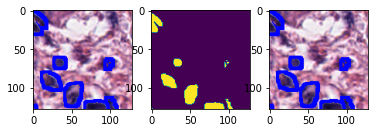

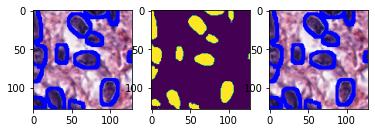

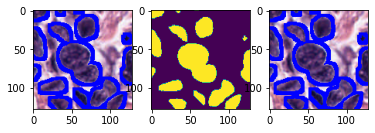

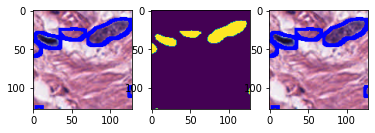

In [57]:
for k in range(0,25) :
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(batch_arr[k,64:-64,64:-64,:])
    ax[1].imshow(output_batch[k])
    ax[2].imshow(outline_mask(batch_arr[k,64:-64,64:-64,:].copy(),output_batch[k].copy(),dilate_width=3))

TypeError: Image data of dtype object cannot be converted to float

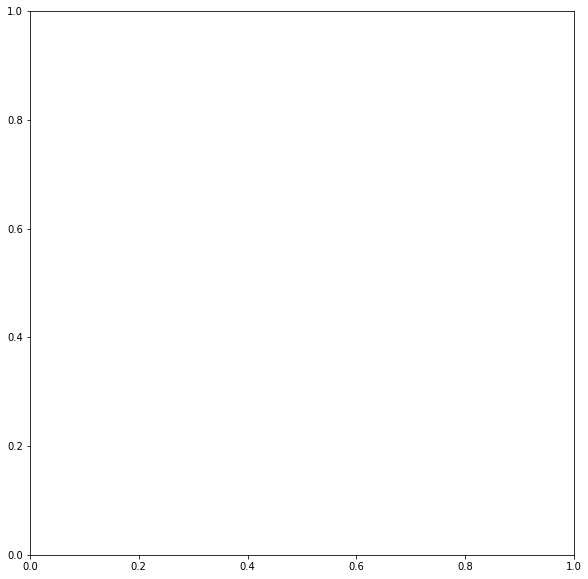

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(output)

In [85]:
fname =files[0]
fname = fname.strip()

xml_dir = fname[0:fname.rfind(os.path.sep)]
xml_fname = xml_dir + os.path.sep + os.path.basename(fname)[0:os.path.basename(fname).rfind('.')] + '.xml'

wsi_img = wsi(fname,xml_fname)

roi_u, mask = wsi_img.get_annotated_region(0.25,'green','largest',mask_out_roi=False)

In [41]:
def outline_mask(img,mask1,dilate_width=10,color=[0,0,255]):
        
    mask1_dilated = (cv2.dilate(mask1.astype(np.uint8),np.ones((dilate_width,dilate_width))) - mask1)*255
        
    img[:,:,0][mask1_dilated>0] = color[0]        
    img[:,:,1][mask1_dilated>0] = color[1]
    img[:,:,2][mask1_dilated>0] = color[2]
    
    return img

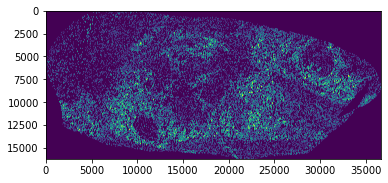

In [78]:
output = plt.imread('/mnt/rstor/CSE_BME_AXM788/home/pjl54/test/TCGA-ZF-AA5P-01Z-00-DX1.svs_class.png')
plt.imshow(output)

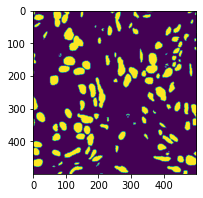

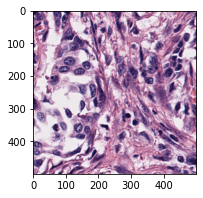

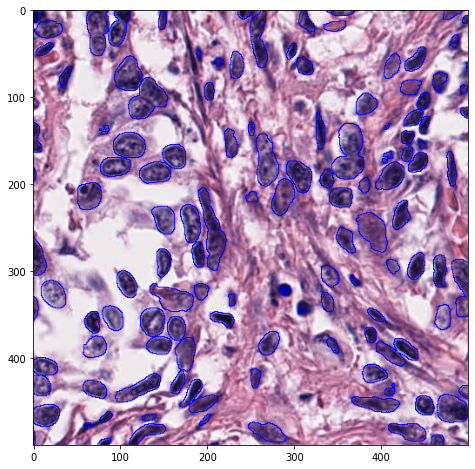

In [243]:
x1 = 6000
x2 = 6500

y1 = 6000
y2 = 6500

plt.figure(figsize=(3,3))
plt.imshow(output_pre[x1:x2,y1:y2])
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(roi_u[x1:x2,y1:y2,:])
plt.show()

# fig, ax = plt.subplots(1,3,figsize=(12,4))
# ax[0].imshow(np.uint8(np.abs(np.int16(output_pre_roi[x1:x2,y1:y2,0])-roi_u[x1:x2,y1:y2,0])))
# ax[1].imshow(np.uint8(np.abs(np.int16(output_pre_roi[x1:x2,y1:y2,1])-roi_u[x1:x2,y1:y2,1])))
# ax[2].imshow(np.uint8(np.abs(np.int16(output_pre_roi[x1:x2,y1:y2,2])-roi_u[x1:x2,y1:y2,2])))

# print(np.uint8(np.abs(np.int16(output_pre_roi[x1:x2,y1:y2,0])-roi_u[x1:x2,y1:y2,0])))
plt.figure(figsize=(8,8))
plt.imshow(outline_mask(roi_u[x1:x2,y1:y2,:].copy(),output_pre[x1:x2,y1:y2].copy(),dilate_width=3))
plt.show()


In [114]:
print(roi_u[0:10,0:10,0])
print(output_pre_roi[0:10,0:10,0])

[[101 115 116  64  89 123 136 123  97  74]
 [132 124 110  49  79 114 123 102  76  62]
 [127 101  79  69  96 129 142 131 111  97]
 [ 96  70  61  82  96 125 157 175 167 135]
 [ 68  55  65  61  63  86 136 184 186 135]
 [ 58  48  48  51  44  57  99 145 153 112]
 [ 90  84  84  45  44  59  95 130 131  94]
 [138 134 131  77  75  84  99 111 105  78]
 [173 166 155 131 122 109  95  84  81  82]
 [177 161 143 141 124  93  63  49  65 102]]
[[121 125  96  55  98 127 126 103  77  63]
 [132 113  81  55  98 126 122  97  75  69]
 [107  78  69  84 112 142 153 144 125 108]
 [ 72  57  66  81  95 128 169 189 169 123]
 [ 53  51  59  53  56  88 145 183 164 103]
 [ 61  56  53  43  42  65 111 144 131  82]
 [107 106  87  45  56  77 109 127 110  68]
 [155 151 130  91  95  97 100 100  88  67]
 [178 164 150 138 123  98  76  68  77  93]
 [165 142 128 123  99  65  41  46  84 134]]


In [95]:
np.max(roi_u)

255

(768, 768, 3)
(25, 256, 256, 3)
(25, 256, 256, 3)
-63
(256, 256, 3)
(256, 256, 3)


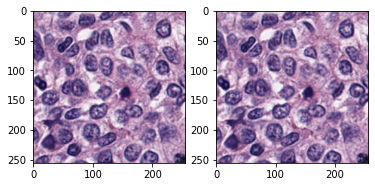

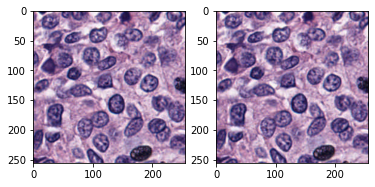

In [136]:
print(np.shape(big_patch))
print(np.shape(batch_arr))
print(np.shape(batch_arr_old))

# import matplotlib.pyplot as plt
# plt.imshow(big_patch)
# plt.show()

print(np.shape(batch_arr_old[0]))
print(np.shape(batch_arr[0]))

fig, ax = plt.subplots(1,2)
ax[0].imshow(batch_arr_old[0,:,:,:])
ax[1].imshow(batch_arr[0])

fig, ax = plt.subplots(1,2)
ax[0].imshow(batch_arr_old[1,:,:,:])
ax[1].imshow(batch_arr[1])


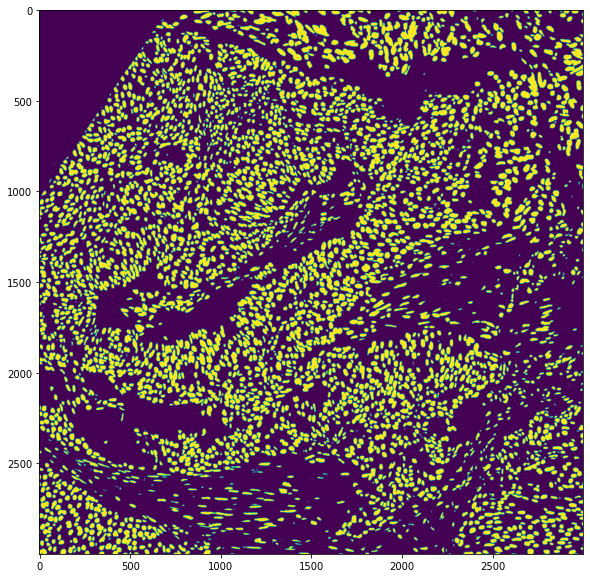

In [267]:
plt.figure(figsize=(10,10))
plt.imshow(output[2000:5000,2000:5000])

In [127]:
print(np.shape(output_batch))

(25, 128, 128)


In [19]:
%load_ext line_profiler
%lprun -f do_stuff out=do_stuff(files,OUTPUT_DIR,args)

working on file: 	 /mnt/rstor/CSE_BME_AXM788/data/TCGA_Bladder_Cancer/Diagnostic_Images/Elloitt/1stAnnotatedDrElloitt/TCGA-4Z-AA7O-01Z-00-DX1.svs
saving to : 	  /mnt/rstor/CSE_BME_AXM788/home/pjl54/test/TCGA-4Z-AA7O-01Z-00-DX1.svs_class.png
Elapsed time = 145.96465587615967


In [15]:
# test for those wicked bladders
fname = files[0]
    
fname = fname.strip()
newfname_class = "%s/%s_class.png" % (OUTPUT_DIR, os.path.basename(fname)[0:fname.rfind('.')])

print(f"working on file: \t {fname}")
print(f"saving to : \t {newfname_class}")

start_time = time.time()
cv2.imwrite(newfname_class, np.zeros(shape=(1, 1)))                                            

xml_dir = fname[0:fname.rfind(os.path.sep)]
xml_fname = xml_dir + os.path.sep + os.path.basename(fname)[0:os.path.basename(fname).rfind('.')] + '.xml'

img = wsi(fname,xml_fname)

stride_size = int(base_stride_size * (args.resolution/img["mpp"]))

if(args.annotation.lower() == 'wsi'):
    img_dims = [0,0,img["img_dims"][0][0],img["img_dims"][0][1]]
else:
    img_dims = img.get_dimensions_of_annotation(args.color,args.annotation)

x_start = int(img_dims[0])
y_start = int(img_dims[1])
w_orig = int(img_dims[2]) - x_start
h_orig = int(img_dims[3]) - y_start


w = int(w_orig + (patch_size - (w_orig % patch_size)))
h = int(h_orig + (patch_size - (h_orig % patch_size)))

x_points = range(x_start-stride_size//2,x_start+w+stride_size//2,stride_size)
y_points = range(y_start-stride_size//2,y_start+h+stride_size//2,stride_size)

grid_points = [(x,y) for x in x_points for y in y_points]                
# should have a line here to only use points inside the annotation

points_split = divide_batch(grid_points,batch_size)

#in case we have a large network, lets cut the list of tiles into batches
output = np.zeros((len(grid_points),base_stride_size,base_stride_size),np.uint8)


working on file: 	 /mnt/rstor/CSE_BME_AXM788/data/TCGA_Bladder_Cancer/Diagnostic_Images/Elloitt/1stAnnotatedDrElloitt/TCGA-4Z-AA7O-01Z-00-DX1.svs
saving to : 	 /mnt/data/home/pjl54/bladder/test/TCGA-4Z-AA7O-01Z-00-DX1.svs_class.png


In [16]:
output.shape

(10925, 128, 128)

In [142]:
batch_points = next(points_split)
print([batch_points[0][0]-x_start,batch_points[0][1]-y_start])

[2331, 4347]


In [143]:
# batch_points = next(points_split)
print(batch_points[0])
batch_arr = np.array([img.get_tile(args.resolution,coords,(patch_size,patch_size)) for coords in batch_points])

(61656, 30982)


In [150]:
batch_arr.shape
print(args.resolution)
print(patch_size)

0.25
256


In [145]:
print(x_start)
print(stride_size//2)
print(x_points[0])

59325
63
59262


(61656, 30982)
[2331, 4347]


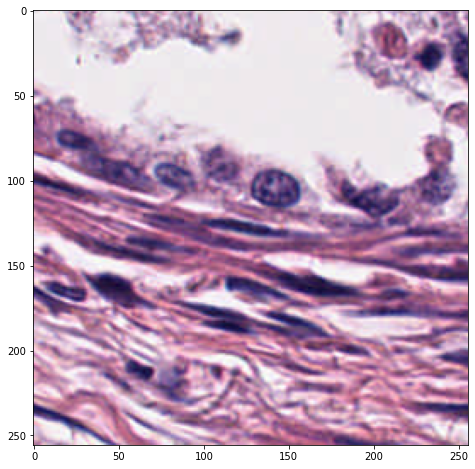

In [147]:
print(batch_points[0])
print([batch_points[0][0]-x_start,batch_points[0][1]-y_start])
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(batch_arr[0,:,:,:])
plt.show()

In [220]:
# do images

for fname in files:    
    fname = fname.strip()
    newfname_class = "%s/%s_class.png" % (OUTPUT_DIR, os.path.basename(fname)[0:fname.rfind('.')])

    print(f"working on file: \t {fname}")
    print(f"saving to : \t {newfname_class}")

#     if not args.force and os.path.exists(newfname_class):
#         print("Skipping as output file exists")
#         continue
    start_time = time.time()
    cv2.imwrite(newfname_class, np.zeros(shape=(1, 1)))                                            

    xml_dir = fname[0:fname.rfind(os.path.sep)]
    xml_fname = xml_dir + os.path.sep + os.path.basename(fname)[0:os.path.basename(fname).rfind('.')] + '.xml'

    img = wsi(fname,xml_fname)

    stride_size = int(base_stride_size * (args.resolution/img["mpp"]))

    if(args.annotation.lower() == 'wsi'):
        img_dims = [0,0,img["img_dims"][0][0],img["img_dims"][0][1]]
    else:
        img_dims = img.get_dimensions_of_annotation(args.color,args.annotation)

    if img_dims:

        x_start = int(img_dims[0])
        y_start = int(img_dims[1])
        w_orig = int(img_dims[2]) - x_start
        h_orig = int(img_dims[3]) - y_start


        w = int(w_orig + (patch_size - (w_orig % patch_size)))
        h = int(h_orig + (patch_size - (h_orig % patch_size)))
                

        #in case we have a large network, lets cut the list of tiles into batches

        base_edge_length = base_stride_size*int(math.sqrt(batch_size))        
    
        divisible_wh = tuple([k + ((base_edge_length + base_stride_size) - (k % (base_edge_length + base_stride_size))) for k in [w,h]])
        
#         roi = img.get_tile(args.resolution,(x_start-stride_size//2,y_start-stride_size//2),divisible_wh)
        
#         x_points = range(x_start-stride_size//2,x_start+w+stride_size//2,stride_size*int(math.sqrt(batch_size)))
#         y_points = range(y_start-stride_size//2,y_start+h+stride_size//2,stride_size*int(math.sqrt(batch_size)))
    
        x_points = range(0,np.shape(roi)[0],base_stride_size*int(math.sqrt(batch_size)))
        y_points = range(0,np.shape(roi)[1],base_stride_size*int(math.sqrt(batch_size)))
        grid_points = [(x,y) for x in x_points for y in y_points]                

        output_roi = np.zeros(np.shape(roi),dtype='uint8')
        
        out_counter = 0
        n_x = np.shape(output)[0]/base_edge_length

        x_counter = 0
        y_counter = 0

        for i,batch_points in enumerate(grid_points):

            # get the tile of the batch
            big_patch = roi[batch_points[0]:(batch_points[0]+base_edge_length+base_stride_size),batch_points[1]:(batch_points[1]+base_edge_length+base_stride_size),:]

            # split the tile into patch_size patches
            batch_arr = np.array([big_patch[x:x+patch_size,y:y+patch_size,:] for y in range(0,np.shape(big_patch)[1]-base_stride_size,base_stride_size) for x in range(0,np.shape(big_patch)[0]-base_stride_size,base_stride_size)])
            n_in_batch = np.shape(batch_arr)[0]
            
            output_batch = batch_arr
            
            #remove the padding from each tile, we only keep the center
            output_batch = output_batch[:,base_stride_size//2:-base_stride_size//2,base_stride_size//2:-base_stride_size//2,:]            

            reconst = np.concatenate(np.concatenate(output_batch.reshape(int(np.shape(big_patch)[1]/(patch_size//2))-1,int(np.shape(big_patch)[0]/(patch_size//2))-1,base_stride_size,base_stride_size,3),axis=2),axis=0)

            output_roi[batch_points[0]:(batch_points[0]+np.shape(big_patch)[0]-base_stride_size),batch_points[1]:(batch_points[1]+np.shape(big_patch)[1]-base_stride_size),:] = reconst
            x_counter = x_counter + 1

            if(x_counter == n_x):
                x_counter = 0
                y_counter = y_counter + 1

        if(args.annotation.lower() == 'wsi'):
            cv2.imwrite(newfname_class,(output>0)*255)
        else:

        #in case there was extra padding to get a multiple of patch size, remove that as well
            _,mask = img.get_annotated_region(args.resolution,args.color,args.annotation,return_img=False)
            output_pre_roi = output_roi
            output_roi = output_roi[0:mask.shape[0], 0:mask.shape[1]] #remove paddind, crop back
            output_roi = np.bitwise_and(output_roi>0,mask>0)*255            

    else:
        print('No annotation of color')

#     output = None
#     output_batch = None
#     mask = None
    print('Elapsed time = ' + str(time.time()-start_time))
#         return output


working on file: 	 /mnt/rstor/CSE_BME_AXM788/data/TCGA_Bladder_Cancer/Diagnostic_Images/Elloitt/1stAnnotatedDrElloitt/TCGA-4Z-AA7O-01Z-00-DX1.svs
saving to : 	  /mnt/rstor/CSE_BME_AXM788/home/pjl54/test/TCGA-4Z-AA7O-01Z-00-DX1.svs_class.png


ValueError: operands could not be broadcast together with shapes (14437,11699,3) (14437,11699) 

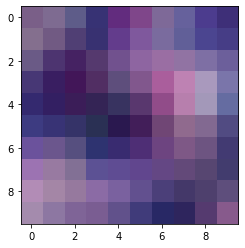

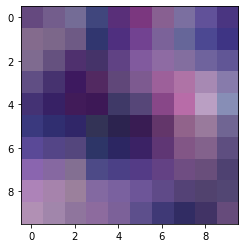

[[122 126  94  55  98 127 126 102  76  62]
 [132 113  80  56  99 127 122  97  75  70]
 [106  77  69  85 113 142 154 145 126 108]
 [ 71  57  66  81  94 129 170 190 169 122]
 [ 52  51  59  52  56  89 145 183 163 101]
 [ 61  56  53  42  42  66 112 144 130  81]
 [107 107  86  46  57  78 109 126 109  66]
 [156 152 130  92  95  97 100  99  87  66]
 [178 164 150 139 122  98  75  68  78  94]
 [164 141 127 122  97  64  40  46  85 135]]
[[101 115 116  64  89 123 136 123  97  74]
 [132 124 110  49  79 114 123 102  76  62]
 [127 101  79  69  96 129 142 131 111  97]
 [ 96  70  61  82  96 125 157 175 167 135]
 [ 68  55  65  61  63  86 136 184 186 135]
 [ 58  48  48  51  44  57  99 145 153 112]
 [ 90  84  84  45  44  59  95 130 131  94]
 [138 134 131  77  75  84  99 111 105  78]
 [173 166 155 131 122 109  95  84  81  82]
 [177 161 143 141 124  93  63  49  65 102]]


In [228]:
x1 = 0
x2 = 10

y1 = 0
y2 = 10

plt.imshow(output_pre_roi[x1:x2,y1:y2,:])
plt.show()

plt.imshow(roi_u[x1:x2,y1:y2,:])
plt.show()

print(output_pre_roi[x1:x2,y1:y2,0])
print(roi_u[x1:x2,y1:y2,0])

(1664, 1664, 3)
(1536, 1536, 3)
[13.0, 13.0, 0.0234375]
(12288, 0)
(14976, 13312, 3)
[9.75, 8.666666666666666, 0.001953125]
[7.666666666666667, 9.333333333333334]


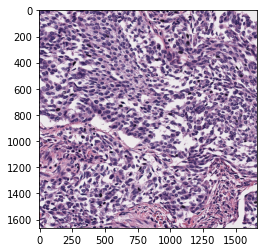

In [219]:
plt.imshow(big_patch)
print(np.shape(big_patch))
print(np.shape(reconst))
print([k/(patch_size//2) for  k in np.shape(big_patch)])
print(batch_points)
print(np.shape(roi))
print([k/base_edge_length for k in np.shape(roi)])
print([k/base_edge_length for k in [w,h]])

In [180]:
print((base_stride_size*int(math.sqrt(batch_size))+base_stride_size,base_stride_size*int(math.sqrt(batch_size))+base_stride_size))
print(img.get_layer_for_mpp(0.25,(base_stride_size*int(math.sqrt(batch_size))+base_stride_size,base_stride_size*int(math.sqrt(batch_size))+base_stride_size)))

print(img.get_layer_for_mpp(0.25,(img_dims[2]-img_dims[0],img_dims[3]-img_dims[1])))

print((base_stride_size*int(math.sqrt(batch_size))+base_stride_size)/(img_dims[2]-img_dims[0]))
print(1647/11469)

print(.000046/.1436044)

(1664, 1664)
(0, 0.9900990099009901, [1647, 1647])
(0, 0.9900990099009901, [11469, 14153])
0.143646408839779
0.14360449908448863
0.00032032444688324317


In [222]:
print(grid_points[0])
print(img_dims)
grid_tile = img.get_tile(args.resolution,grid_points[0],(base_stride_size*int(math.sqrt(batch_size))+base_stride_size,base_stride_size*int(math.sqrt(batch_size))+base_stride_size))
roi_tile = roi_u[0:(base_stride_size*int(math.sqrt(batch_size))+base_stride_size),0:(base_stride_size*int(math.sqrt(batch_size))+base_stride_size),:]

batch_arr = np.array([grid_tile[x:x+patch_size,y:y+patch_size,:] for y in range(0,np.shape(big_patch)[1]-base_stride_size,base_stride_size) for x in range(0,np.shape(big_patch)[0]-base_stride_size,base_stride_size)])
n_in_batch = np.shape(batch_arr)[0]

output_batch = batch_arr

#remove the padding from each tile, we only keep the center
output_batch = output_batch[:,base_stride_size//2:-base_stride_size//2,base_stride_size//2:-base_stride_size//2,:]            


reconst = np.concatenate(np.concatenate(output_batch.reshape(int(math.sqrt(batch_size)),int(math.sqrt(batch_size)),base_stride_size,base_stride_size,3),axis=2),axis=0)


x1 = 0
x2 = 20

y1 = 0
y2 = 20

# plt.imshow(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),:])
# plt.show()

plt.imshow(roi_tile[x1:x2,y1:y2,:])
plt.show()

# plt.imshow(reconst[x1:x2,y1:y2,:])
# plt.show()

plt.imshow(output_pre_roi[x1:x2,y1:y2,:])
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),0])-roi_tile[x1:x2,y1:y2,0])))
ax[1].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),1])-roi_tile[x1:x2,y1:y2,1])))
ax[2].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),2])-roi_tile[x1:x2,y1:y2,2])))

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),0])-reconst[x1:x2,y1:y2,0])))
ax[1].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),1])-reconst[x1:x2,y1:y2,1])))
ax[2].imshow(np.uint8(np.abs(np.int16(grid_tile[(x1+64):(x2+64),(y1+64):(y2+64),2])-reconst[x1:x2,y1:y2,2])))

# print(np.uint8(np.abs(np.int16(grid_tile[x1:x2,y1:y2,0])-roi_tile[x1:x2,y1:y2,0])))


(0, 0)
(59325.0, 26635.0, 70909.0, 40930.0)


ValueError: cannot reshape array of size 2752512 into shape (12,12,128,128,3)

In [160]:
print(np.shape(batch_arr))
print(np.shape(reconst))
print(np.shape(grid_tile))

(144, 256, 256, 3)
(1536, 1536, 3)
(1664, 1664, 3)


In [154]:
[[range(x+64,x+patch_size-64),range(y+64,y+patch_size-64)] for y in range(0,np.shape(big_patch)[1]-base_stride_size,base_stride_size) for x in range(0,np.shape(big_patch)[0]-base_stride_size,base_stride_size)]

[[range(64, 192), range(64, 192)],
 [range(192, 320), range(64, 192)],
 [range(320, 448), range(64, 192)],
 [range(448, 576), range(64, 192)],
 [range(576, 704), range(64, 192)],
 [range(704, 832), range(64, 192)],
 [range(832, 960), range(64, 192)],
 [range(960, 1088), range(64, 192)],
 [range(1088, 1216), range(64, 192)],
 [range(1216, 1344), range(64, 192)],
 [range(1344, 1472), range(64, 192)],
 [range(1472, 1600), range(64, 192)],
 [range(64, 192), range(192, 320)],
 [range(192, 320), range(192, 320)],
 [range(320, 448), range(192, 320)],
 [range(448, 576), range(192, 320)],
 [range(576, 704), range(192, 320)],
 [range(704, 832), range(192, 320)],
 [range(832, 960), range(192, 320)],
 [range(960, 1088), range(192, 320)],
 [range(1088, 1216), range(192, 320)],
 [range(1216, 1344), range(192, 320)],
 [range(1344, 1472), range(192, 320)],
 [range(1472, 1600), range(192, 320)],
 [range(64, 192), range(320, 448)],
 [range(192, 320), range(320, 448)],
 [range(320, 448), range(320, 448)]